# Flattener

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.external.tifffile as tif
import scipy.signal
import scipy.ndimage as ndi
import tqdm
import mrcfile
import os
%load_ext autoreload
%autoreload 2

import fibflatten as ff

In [2]:
# data has been downsampled by a factor of 8 in each dimension to give 64 nm voxels.
with mrcfile.open("Cryo_LoadID328_Cell15 64x64x64nm.mrc") as fp:
    data = np.array(fp.data.view("uint8"))

In [3]:
plt.set_cmap("Greys_r")

<Figure size 432x288 with 0 Axes>

In [4]:
data.dtype

dtype('uint8')

C:\Users\hoffmand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


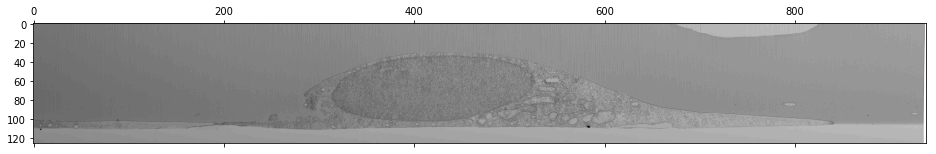

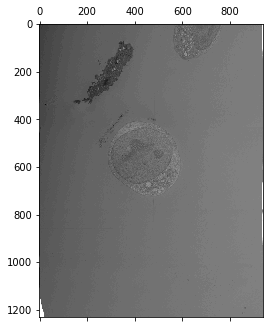

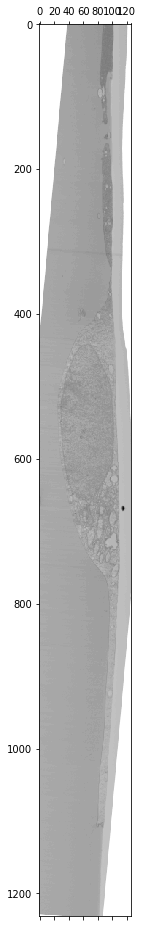

In [5]:
# ortho slices through the center
center = np.asarray(data.shape) // 2
for i, c in enumerate(center):
    s = [slice(None)] * 3
    s[i] = c
    plt.matshow(data[s])

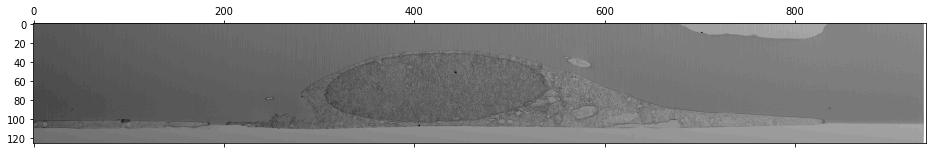

In [6]:
plt.matshow(data[600])

In [8]:
mask = data == 255

In [9]:
mask2 = ndi.binary_dilation(mask)

In [10]:
data = data.astype(float)

In [15]:
data[mask2] = np.nan

96

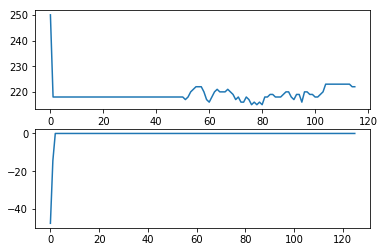

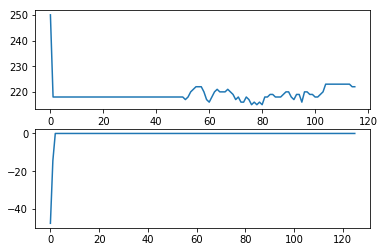

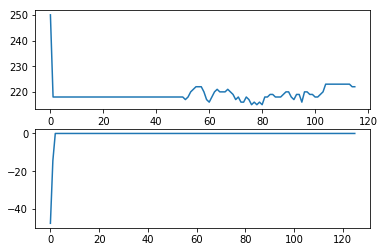

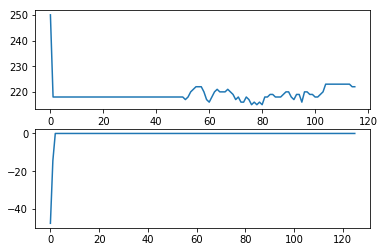

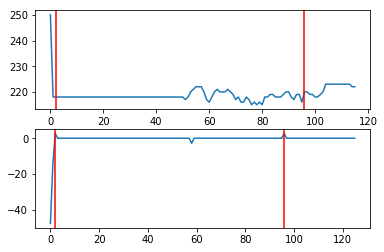

In [34]:
ff.find_edge_line(data[430, :, 402], win=5, diagnostics=True)

Wall time: 651 ms


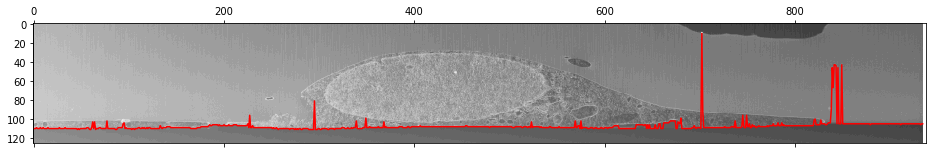

In [35]:
%time a = ff.find_edge_plane(data[600], win=5, diagnostics=True)

Wall time: 2.88 s


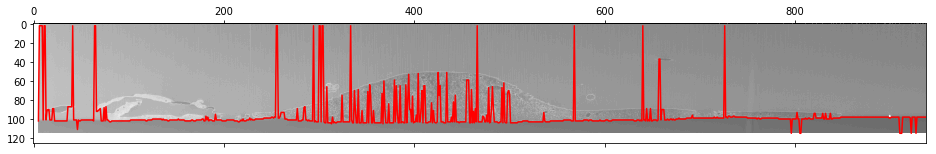

In [36]:
%time a = ff.find_edge_plane(data[430], win=5, diagnostics=True)

In [19]:
data.shape

(1232, 126, 938)

In [20]:
import tqdm

In [21]:
import dask
from dask.diagnostics.progress import ProgressBar

In [39]:
with ProgressBar():
    result = np.array(dask.delayed([dask.delayed(ff.find_edge_plane)(d) for d in data]).compute(scheduler="processes"))

[########################################] | 100% Completed | 45.2s


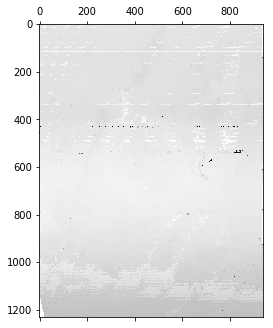

In [40]:
plt.matshow(result)

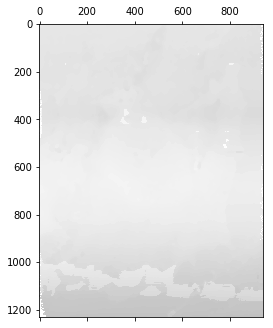

In [41]:
med_baseline = scipy.ndimage.median_filter(result, 17)
plt.matshow(med_baseline)

## Plan

There are two types of issues, those do to the `SIFT` alignment algorithm and those do to actual physical problems, i.e. when removing the coverslip. There may also be a general rotation.

Therefore we have the following plan
1. find edge
2. Deal with SIFT first:
    1. Find best rotation angle
    2. Subtract trend perpendicular to milling direction
3. Deal with further warping:
    1. rolling ball filter remaining baseline
    2. rotate (if necessary)
    3. remove baseline

In [42]:
tif.imsave("64x64x64nm_baseline.tif", result)

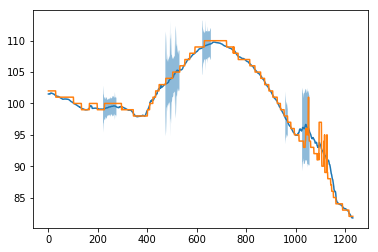

In [43]:
bm = np.nanmean(med_baseline, 1)
bm2 = np.nanmedian(med_baseline, 1)
bs = result.std(1)
x = np.arange(bs.size)
plt.fill_between(x, bm - bs, bm + bs, alpha=0.5)

plt.plot(x, bm)
plt.plot(x, bm2)

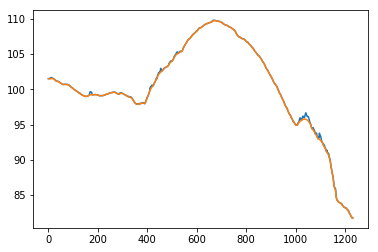

In [44]:
plt.plot(x, bm)
bm2 = ff.rolling_ball_filter(bm, 30, top=False)[1]
plt.plot(x, bm2)

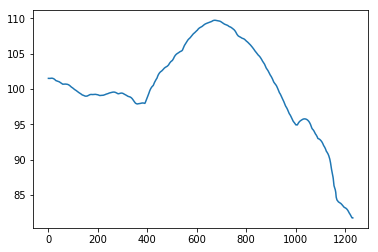

In [45]:
plt.plot(x, bm2)

C:\Users\hoffmand\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


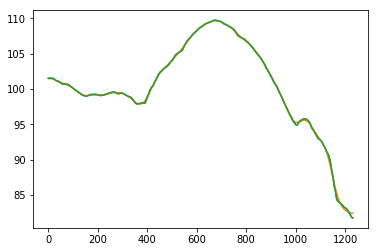

In [46]:
fig, ax = plt.subplots()
ax.plot(bm2)
bm3 = scipy.signal.filtfilt(*scipy.signal.butter(3, 0.025), bm2)
bm4 = scipy.ndimage.gaussian_filter1d(bm2, 2)
ax.plot(bm3)
ax.plot(bm4)
# ax.set_aspect(1)

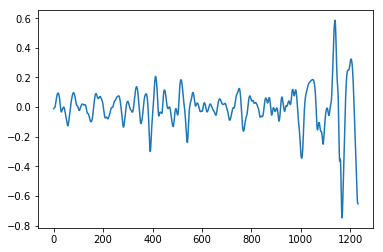

In [47]:
plt.plot(bm4-bm3)

In [48]:
baseline = bm2 - bm2.mean()

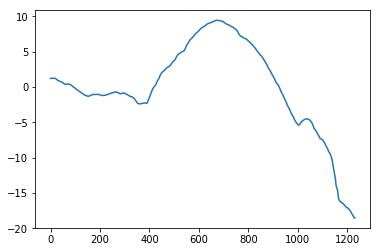

In [52]:
plt.plot(baseline)

In [56]:
data_flatten = np.dstack([ndi.shift(d, (-b, 0), order=1) for d, b in zip(tqdm.tqdm_notebook(np.nan_to_num(data).astype("uint8")), baseline)])

In [57]:
tif.imsave("Cryo_LoadID277_Cell11 64x64x64nm_flat.tif", data_flatten)

In [58]:
%%time
%time datafile = mrcfile.mmap("Cryo_LoadID328_Cell15 8x8x8nm.mrc")
%time datalarge = datafile.data.view("uint8")

Wall time: 3 ms
Wall time: 0 ns
Wall time: 6 ms


In [59]:
from scipy.interpolate import interp1d

In [60]:
bm4_interp = interp1d(np.arange(len(baseline)), baseline, "cubic", bounds_error=False, fill_value=baseline.mean())

In [61]:
bm4_i = bm4_interp(np.arange(datalarge.shape[0]) / 8) * 8

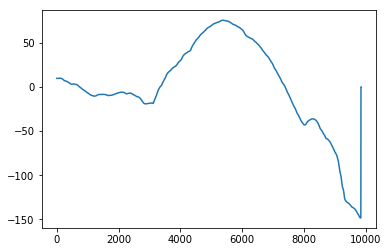

In [62]:
plt.plot(bm4_i)

In [64]:
import gc
gc.collect()

770

In [65]:
import dask.array as da

In [66]:
datalarge.shape

(9859, 1009, 7509)

In [40]:
@dask.delayed
def load_shift(i, b):
    datafile = mrcfile.mmap("Cryo_LoadID328_Cell15 8x8x8nm.mrc")
    datalarge = datafile.data.view("uint8")
    return ndi.shift(datalarge[i], (-b, 0))

bm4_i.shape

flat = dask.delayed([load_shift(i, b) for i, b in enumerate(tqdm.tqdm_notebook(bm4_i))])

from dask.diagnostics import ProgressBar

with ProgressBar():
    flat = np.array(flat.compute())

In [67]:
%%time
datafile = mrcfile.mmap("Cryo_LoadID328_Cell15 8x8x8nm.mrc")
datalarge = datafile.data.view("uint8")
%time datalarge_new = np.empty_like(datalarge)
# %time datalarge_new_rolled = np.rollaxis(datalarge_new, -1)
# %time rolled_array = np.rollaxis(datalarge, -1)
flat = dask.delayed([dask.delayed(ndi.shift)(d, (-b, 0), dn) for d, b, dn in zip(datalarge, bm4_i, datalarge_new)])

with ProgressBar():
    flat.compute()

Wall time: 527 ms
[########################################] | 100% Completed | 10min 51.1s
Wall time: 10min 52s


In [69]:
%%time
%time flatfile = mrcfile.mmap("Cryo_LoadID328_Cell15 8x8x8nm_flat.mrc", "w+")
%time flatfile._close_data()
%time flatfile._set_new_data(datalarge_new.view("int8"))
for d in datafile.header.dtype.fields:
    print(datafile.header[d])
    flatfile.header[d] = datafile.header[d]
flatfile.close()

Wall time: 1.97 ms
Wall time: 3 ms
Wall time: 20min 22s
7509
1009
9859
0
0
0
0
7509
1009
9859
(600720., 80720., 788720.)
(90., 90., 90.)
1
2
3
22.0
255.0
223.44421
0
0
b'\x00\x00\x00\x00\x00\x00\x00\x00'
b'    '
0
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x49\x4D\x4F\x44\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xFF\xFF\x9F\x40\x00\x00\x00\x00\x00\x00\x00\x00'
(360., 24920.996, -2857.1094)
b'MAP '
[68 68  0  0]
-1.0
4
[b'tif2mrc: Converted to MRC format.                       03-Sep-18  08:48:22     '
 b'NEWSTACK: Images copied, transformed, densities scaled   3-Sep-18  10:11:36     '
 b'BINVOL: Volume binned down by factors   1   1   2        3-Sep-18  11:22:12     '
 b'ROTATEVOL: 3D rotation by angles:    5.0    0.0    0.0   3-Sep-18  13:39:49     '
 b'' b'' b'' b'' b'' b'']
Wall time: 21min 55s


In [70]:
gc.collect()

19750

In [70]:
flatfile.header.nx = flatfile.header.mx = new_data.shape[2]
flatfile.header.ny = flatfile.header.my = new_data.shape[1]
flatfile.header.nz = new_data.shape[0]
flatfile.header.mz = 1

In [71]:
flatfile.header.dmin = new_data.min()
flatfile.header.dmax = new_data.max()

# Use a float64 accumulator to calculate mean and standard deviation
# This prevents overflow errors during calculation
flatfile.header.dmean = 0 # np.float32(new_data.mean(dtype=np.float64))
flatfile.header.rms = 0 # np.float32(new_data.std(dtype=np.float64))

In [72]:
flatfile.close()

In [73]:
datafile.close()
gc.collect()

0

In [67]:
flatfile = mrcfile.mmap("Cryo_20170714_CS2_Cell6 8x8x8nm_flat.mrc", "w+")

In [ ]:
flatfile._close_data()
flatfile._set_new_data(flat.view("int8"))